# Recurrent Neural Network Model for Rain Forecasting

This notebook builds a model to predict whether or not it will rain tomorrow in Australia using real-world weather data using Recurrent Neural Network with PyTorch. It starts by preprocessing then converting the data to tensors, then building the neural network model with pytorch, then using a loss function and an optimiser to train the model and finally
evaluating the model. 

The dataset contains daily weather observations from numerous Australian weather stations and can be found on [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)


First step is to import the necessary libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn, optim
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch.nn.functional as func
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
%matplotlib inline

In [50]:
sns.set(style='darkgrid')
sns.set_palette('deep')

In [4]:
# load the dataset
df = pd.read_csv('weatherAUS.csv')

In [53]:
# show first few records
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Year,Month,Day
0,2008-12-01,2,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,8.0,NaN,16.9,21.8,0,0.0,0,2008,12,1
1,2008-12-02,2,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,NaN,NaN,17.2,24.3,0,0.0,0,2008,12,2
2,2008-12-03,2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,NaN,2.0,21.0,23.2,0,0.0,0,2008,12,3
3,2008-12-04,2,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,NaN,NaN,18.1,26.5,0,1.0,0,2008,12,4
4,2008-12-05,2,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,7.0,8.0,17.8,29.7,0,0.2,0,2008,12,5


In [5]:
# show dataset dimensions
df.shape

(142193, 24)

In [6]:
# show dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

In [42]:
# show the frequency distribution of RainTomorrow
df['RainTomorrow'].value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

In [43]:
# show percentage
df['RainTomorrow'].value_counts()/len(df)

0    0.775819
1    0.224181
Name: RainTomorrow, dtype: float64

We can see that out of the total number of RainTomorrow values, No RainTomorrow appears 77.58% times and RainTomorrow appears only 22.42% times. Now let's check for missing data

In [8]:
df.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

We have lots of missing data



# Data Preprocessing

There are two ways to deal with missing values, either by deleting incomplete variables if there are too many data missing or by replacing these missing values with estimated value based on the other information available. So as a rule, any column with more than 2,000 missing value will be excluded as they having more missing values that rest of the variables in the dataset. Then before replaceing missing values of other columns with mean, it's wise to first check for outliers as the mean is greatly affected by outliers and works better if the data is normally-distributed while median imputation is preferable for skewed distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126c09710>,
      dtype=object)

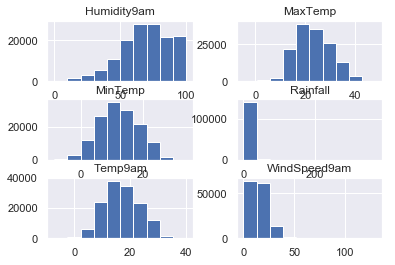

In [10]:
numerical = ['Temp9am', 'MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'WindSpeed9am']
df[numerical].hist()

Show the statistical properties of numerical variables to check for skewed variables

In [11]:
df[numerical].describe()

,Temp9am,MinTemp,MaxTemp,Rainfall,Humidity9am,WindSpeed9am
count,141289.000000,141556.000000,141871.000000,140787.000000,140419.000000,140845.000000
mean,16.987509,12.186400,23.226784,2.349974,68.843810,14.001988
std,6.492838,6.403283,7.117618,8.465173,19.051293,8.893337
min,-7.200000,-8.500000,-4.800000,0.000000,0.000000,0.000000
25%,12.300000,7.600000,17.900000,0.000000,57.000000,7.000000
50%,16.700000,12.000000,22.600000,0.000000,70.000000,13.000000
75%,21.600000,16.800000,28.200000,0.800000,83.000000,19.000000
max,40.200000,33.900000,48.100000,371.000000,100.000000,130.000000


On closer inspection, we can see that the Temp9am, MinTemp, MaxTemp and Rainfall columns seem to have a relatively normal distribution, whilst Humidity9am and WindSpeed9am columns have outliers

In [12]:
# fill missing values of normally-distributed columns with mean and skewed distribution with median
df['Temp9am'] = df['Temp9am'].fillna(value = df['Temp9am'].mean())
df['MinTemp'] = df['MinTemp'].fillna(value = df['MinTemp'].mean())
df['MaxTemp'] = df['MaxTemp'].fillna(value = df['MaxTemp'].mean())
df['Rainfall'] = df['Rainfall'].fillna(value = df['Rainfall'].mean())
df['Humidity9am'] = df['Humidity9am'].fillna(value = df['Humidity9am'].median())
df['WindSpeed9am'] = df['WindSpeed9am'].fillna(value = df['WindSpeed9am'].median())

Next step is to impute missing categorical variables with most frequent value or mode

In [13]:
df['RainToday'] = df['RainToday'].fillna(value = df['RainToday'].mode()[0])

It's well known that categorical data doesn't work with machine learning and deep learning algorithms, so we gonna encode 'Date', 'Location', 'RainToday' and 'RainTomorrow' columns so we can predict whether or not is going to rain tomorrow?

In [14]:
# convert data variable into dattime type
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [15]:
# extract year from the date
df['Year'] = df['Date'].dt.year

In [16]:
# extract month from the date
df['Month'] = df['Date'].dt.month

In [17]:
# extract day from the date
df['Day'] = df['Date'].dt.day

In [18]:
# encode location
le = preprocessing.LabelEncoder()
df['Location'] = le.fit_transform(df['Location'])

In [19]:
# encode RainToday & RainTomorrow
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

Now we have only 9 columns out of 24 after removing variable with many missing data
to predict whether or not is going to rain tomorrow

In [20]:
X = df[['Temp9am', 'MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'WindSpeed9am', 'RainToday', 'Location', 'Year', 'Month', 'Day']]
y = df[['RainTomorrow']]


The final step is to split the data into train and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Then convert all of it to Tensors (so we can use it with PyTorch)

In [22]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

In [23]:
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [24]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(torch.Size([113754, 11]), torch.Size([113754]))
(torch.Size([28439, 11]), torch.Size([28439]))


# Building The Neural Network

We gonna create an input layer from our 11 columns: 'Temp9am', 'MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'WindSpeed9am', 'RainToday', 'Location', 'Year', 'Month' and 'Day'. Then the output will be a number between 0 and 1, representing how likely the model thinks it is gonna rain tomorrow. The prediction will be given out by the final layer of the network. We will add 3 hidden layers between the input and output layers. The parameters of those layer will decide the final output. All layers will be fully-connected. One easy way to build the neural network is to create a class that inherits from torch.nn.Module

In [25]:
# create the model
class Model(nn.Module):
  def __init__(self, n_features):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(n_features, 9)
    self.fc2 = nn.Linear(9, 5)
    self.fc3 = nn.Linear(5, 3)
    self.fc4 = nn.Linear(3, 1)
  def forward(self, x):
    x = func.relu(self.fc1(x))
    x = func.relu(self.fc2(x))
    x = func.relu(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

In [ ]:
model = Model(X_train.shape[1])

We start by creating the layers of our model in the constructor. The forward() method is where the magic happens. It accepts the input x and allows it to flow through each layer. There is a corresponding backward pass (defined by pytorch) that allows the model to learn from the errors that is currently making.

# Training

With the model in place, we need to find parameters that predict will it rain tomorrow. First, we need something to tell us how good we are currently doing:

In [26]:
criterion = nn.BCELoss()

The BCELoss is a loss function that measures the difference between two binary vectors. In our case, the predictions of our model and the real values. It expects the values to be outputed by the sigmoid function. The closer this value gets to 0, the better the model performs.

But how do we find parameters that minimize the loss function?

## Optimisation

Optimisers are used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses. We gonna use Adam optimiser

In [32]:
optimiser = optim.Adam(model.parameters(), lr = 0.001)

Naturally, the optimiser requires the parameters. The second argument lr is learning rate. It is a tradeoff between how good parameters we gonna find and how fast we will get there. Finding good values for this can be black magic

## Doing it on the GPU

Doing massively parallel computations on GPUs is one of the enablers for modern deep learning. We will need nVIDIA GPU to transfer all the computation to it. First we will check whether or not a CUDA is available. Then we gonna transfer all training and test sets to whether GPU or CPU. Finally, we move our model and loss function.

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

model = model.to(device)

In [ ]:
# define the loss function to compare the output with the target
criterion = criterion.to(device)

## Weather Forecasting

Having a loss function is great, but tracking the accuracy of our model is something easier to understand, for us mere mortals. Here is the definition for our accuracy:

In [34]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

We convert every value below 0.5 to 0. Otherwise, we set it to 1. Finally, we calculate the percentage of correct values.

With all the pieces of the puzzle in place, we can start training our model

In [35]:
def round_tensor(t, decimal_places = 3):
  return round(t.item(), decimal_places)

Run the model:

In [36]:
for epoch in range(900):
    y_pred = model(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = model(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print str('epoch ') + str(epoch) + str(' Train set - loss: ') + str(round_tensor(train_loss)) + str(', accuracy: ') + str(round_tensor(train_acc)) + str(' Test  set - loss: ') + str(round_tensor(test_loss)) + str(', accuracy: ') + str(round_tensor(test_acc))
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

epoch 0 Train set - loss: 0.524, accuracy: 0.776 Test  set - loss: 0.522, accuracy: 0.777
epoch 100 Train set - loss: 0.487, accuracy: 0.781 Test  set - loss: 0.487, accuracy: 0.783
epoch 200 Train set - loss: 0.456, accuracy: 0.8 Test  set - loss: 0.457, accuracy: 0.8
epoch 300 Train set - loss: 0.45, accuracy: 0.802 Test  set - loss: 0.452, accuracy: 0.803
epoch 400 Train set - loss: 0.446, accuracy: 0.805 Test  set - loss: 0.449, accuracy: 0.804
epoch 500 Train set - loss: 0.443, accuracy: 0.806 Test  set - loss: 0.447, accuracy: 0.805
epoch 600 Train set - loss: 0.441, accuracy: 0.807 Test  set - loss: 0.445, accuracy: 0.807
epoch 700 Train set - loss: 0.44, accuracy: 0.808 Test  set - loss: 0.443, accuracy: 0.807
epoch 800 Train set - loss: 0.438, accuracy: 0.809 Test  set - loss: 0.443, accuracy: 0.808


# Evaluation

During the training, we show our model the data for 1,000 times. Each time we measure the loss, propagate the errors trough our model and asking the optimiser to find better parameters.

The zero_grad() method clears up the accumulated gradients, which the optimiser uses to find better parameters.

Hmm 80.8% accuracy on the test set sounds reasonable, right? Well, using just accuracy wouldn't be a good way to do it. Recall that our data contains mostly no rain examples! Another way to delve a bit deeper into our model performance is to assess the precision and recall for each class.

In [37]:
classes = ['No rain', 'Raining']

y_pred = model(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.83      0.95      0.89     22098
     Raining       0.65      0.30      0.41      6341

   micro avg       0.81      0.81      0.81     28439
   macro avg       0.74      0.63      0.65     28439
weighted avg       0.79      0.81      0.78     28439



You can see that our model is doing good when it comes to the No rain class. We have so many examples. Unfortunately, we can't really trust predictions of the Raining class. One of the best things about binary classification is that we can have a good look at a simple confusion matrix:

Text(0.5,12.5,'Predicted label')

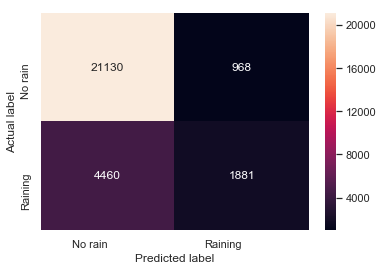

In [52]:
conf_mat = confusion_matrix(y_test, y_pred)
df_conf_mat = pd.DataFrame(conf_mat, index = classes, columns = classes)
heat_map = sns.heatmap(df_conf_mat, annot = True, fmt = 'd')
heat_map.yaxis.set_ticklabels(heat_map.yaxis.get_ticklabels(), ha = 'right')
heat_map.xaxis.set_ticklabels(heat_map.xaxis.get_ticklabels(), ha = 'right')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')